In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-rating-codsoft21/IMDb Movies India.csv


In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor
import optuna
import shap

Data Preparation 
Load the data


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv('/kaggle/input/movie-rating-codsoft21/IMDb Movies India.csv',encoding='ISO-8859-1').drop(columns='Name')

df.dropna(inplace=True)

In [18]:
df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,(2015),115 min,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,(2001),153 min,"Biography, Drama, History",6.2,"1,496",Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,(1989),125 min,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [19]:
df.shape

(5659, 9)

Data cleaning

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [21]:
df.isna().sum()

Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [22]:
df.duplicated().sum()

0

In [23]:
#Handling null values
df.dropna(inplace=True)

In [ ]:
#Handling duplicate values 
df.drop_duplicates(inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [25]:
#Shape of the DataFrame after handling missing and duplicate values
df.shape

(5659, 9)

In [26]:
df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,(2015),115 min,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,(2001),153 min,"Biography, Drama, History",6.2,"1,496",Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,(1989),125 min,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [27]:
# Convert into the correct data types
df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype(int)
df['Duration'] = pd.to_numeric(df['Duration'].str.replace(' min', ''))
df['Votes'] = pd.to_numeric(df['Votes'].str.replace(',', ''))

In [28]:
df.dtypes

Year          int64
Duration      int64
Genre        object
Rating      float64
Votes         int64
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   int64  
 1   Duration  5659 non-null   int64  
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   int64  
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 442.1+ KB


In [30]:
df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,2015,115,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,2001,153,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,1989,125,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,1999,129,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


Exploratory Data Analysis (EDA)

In [31]:
# Descriptive Statistics for all columns
df.describe(include='all')

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,5659.000000,5659.000000,5659,5659.000000,5659.000000,5659,5659,5659,5659
unique,NaN,NaN,376,NaN,NaN,2431,1960,2321,2556
top,NaN,NaN,Drama,NaN,NaN,David Dhawan,Amitabh Bachchan,Rekha,Pran
freq,NaN,NaN,844,NaN,NaN,41,104,52,57
mean,1996.247570,133.439124,NaN,5.898533,2697.649585,NaN,NaN,NaN,NaN
std,19.741839,25.319939,NaN,1.381165,13651.503584,NaN,NaN,NaN,NaN
min,1931.000000,21.000000,NaN,1.100000,5.000000,NaN,NaN,NaN,NaN
25%,1983.000000,119.000000,NaN,5.000000,30.000000,NaN,NaN,NaN,NaN
50%,2002.000000,135.000000,NaN,6.100000,131.000000,NaN,NaN,NaN,NaN
75%,2013.000000,150.000000,NaN,6.900000,922.500000,NaN,NaN,NaN,NaN


Data Visualization

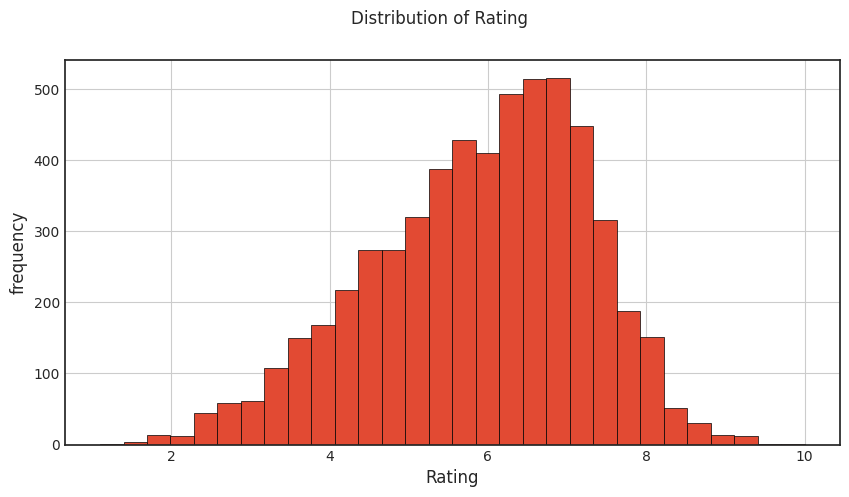

In [35]:
df['Rating'].hist(bins=30, edgecolor='black',figsize=(10, 5))
plt.suptitle('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('frequency')
plt.show()

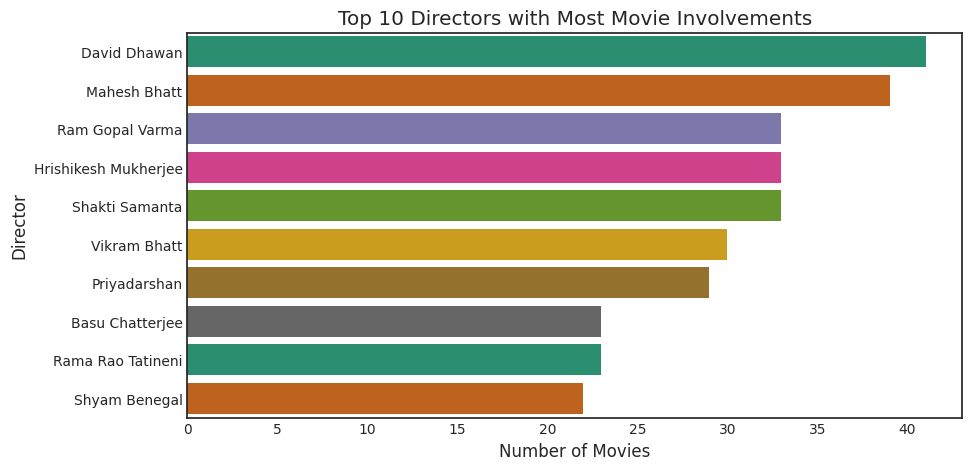

In [36]:
top_10_directors = df['Director'].value_counts(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_directors.values, y=top_10_directors.index,  palette='Dark2')
plt.title('Top 10 Directors with Most Movie Involvements')
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.show()


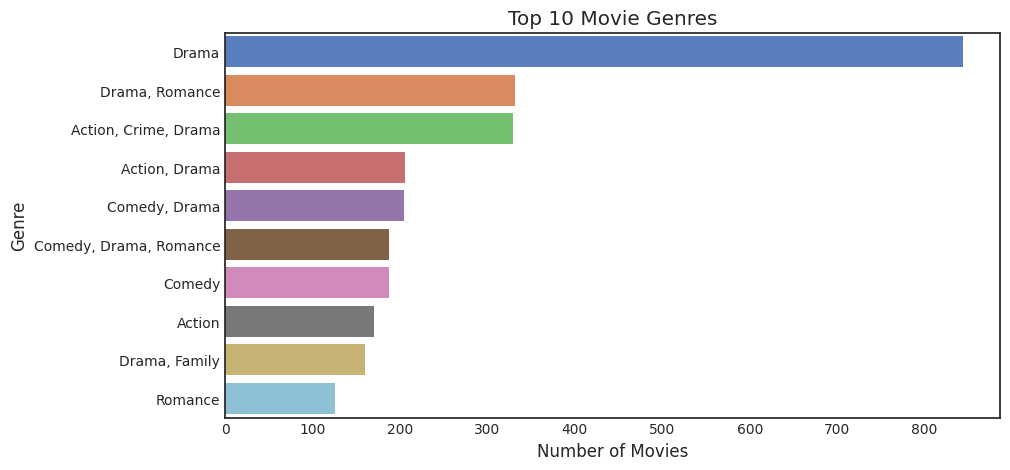

In [37]:
top_10_genres = df['Genre'].value_counts(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_genres.values, y=top_10_genres.index,  palette='muted')
plt.title('Top 10 Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


In [38]:
# Top 10 Actors With Most Movie Involvements
# Combine the three actor columns into one Series
combined_actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']])

# Display the top 10 actors
top_10_actors = combined_actors.value_counts().head(10)
top_10_actors

Mithun Chakraborty    160
Amitabh Bachchan      148
Dharmendra            146
Ashok Kumar           124
Akshay Kumar          120
Shashi Kapoor         117
Jeetendra             116
Sanjay Dutt           101
Rekha                  92
Ajay Devgn             92
Name: count, dtype: int64

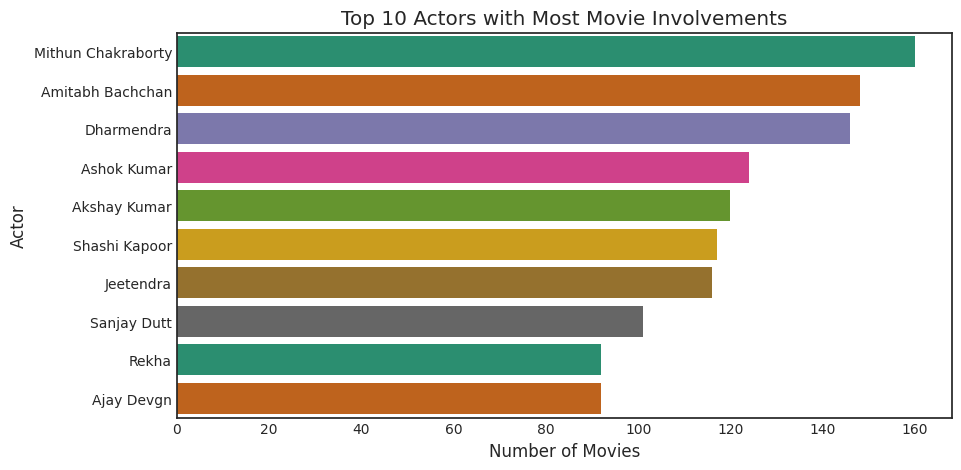

In [39]:
# Plotting the top 10 actors
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_actors.values, y=top_10_actors.index, palette='Dark2')
plt.title('Top 10 Actors with Most Movie Involvements')
plt.xlabel('Number of Movies')
plt.ylabel('Actor')
plt.show()

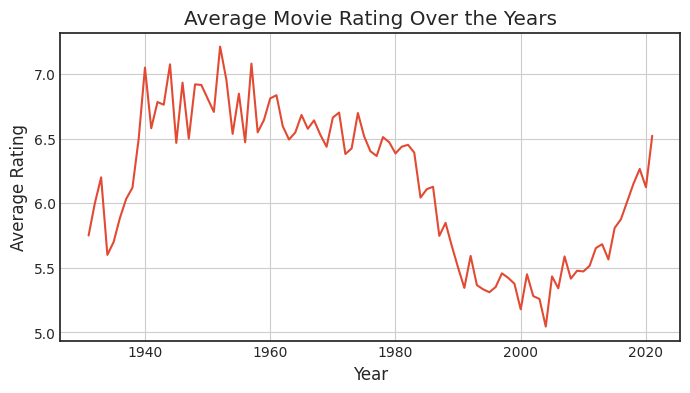

In [40]:
# Average Rating over these years

# Calculate the average rating for each year
average_rating_per_year = df.groupby('Year')['Rating'].mean().reset_index()
average_rating_per_year.columns = ['Year', 'Average Rating']

#Plot
plt.figure(figsize=(8, 4))
plt.plot(average_rating_per_year['Year'], average_rating_per_year['Average Rating'], linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Rating Over the Years')
plt.grid(True)
plt.show()

In [41]:
# High rated movie details
high_rating_movies = df[df['Rating'] > 8.5]
high_rating_movies

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
967,2016,96,"Documentary, Thriller",8.7,1928,Khushboo Ranka,Vinay Shukla,Arvind Kejriwal,Saurabh Bhardwaj
1314,2018,97,Drama,9.3,7,Rahul Mallick,Kunj Anand,Sanjay Bishnoi,Paras Zutshi
1341,2018,127,Drama,8.8,5,Abdul Sattar,Sahil Akhtar,Himayat Ali,Aman Jain
1432,2020,101,Drama,8.7,21,Rajat Kumar Chaturvedi,Arjun Chakrabarty,Trishala Idnani,Sarvagya Jain
1469,2017,117,Drama,8.8,5,Vishal Mourya,Bharat Chawla,Nemi Chandra Jha,Moumita Nandi
1709,2019,120,Comedy,8.8,23,Sanjay Puran Singh Chauhan,Narottam Bain,Aamir Bashir,Pawan Malhotra
1729,2021,72,Family,9.3,29,Vishwa Bhanu,Vishwa Bhanu,Sangam Shukla,Vijay Thakur
2093,1970,136,Drama,8.7,10,Babubhai Mistry,Niranjan Sharma,Shalini,Trilok Kapoor
2437,2020,120,Thriller,8.6,38,Hemant N Mishra,Samiksha Bhatnagar,Rahul Chawla,Abhilash Dada
2709,2016,134,Animation,8.6,656,Harry Baweja,Harman Baweja,Pawan Kalra,Om Puri


In [46]:
print(high_rating_movies.columns)

Index(['Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1',
       'Actor 2', 'Actor 3'],
      dtype='object')


In [54]:
high_rating_movies = df[df['Rating'] > 8.5]  # Replace df with your original DataFrame variable
high_rating_movies['Rating'] = pd.to_numeric(high_rating_movies['Rating'], errors='coerce')


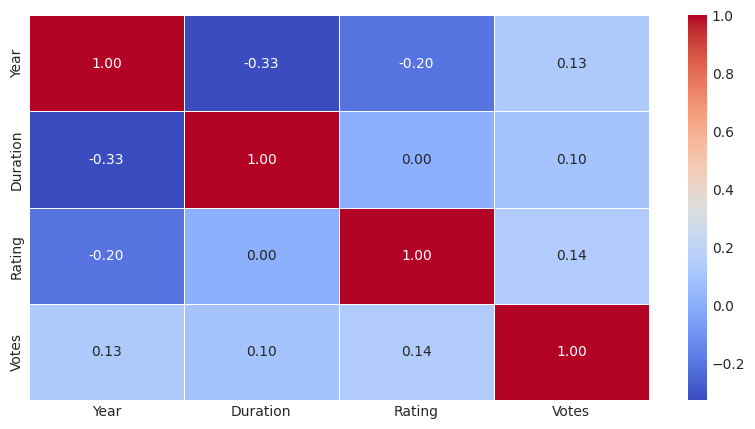

In [59]:
columns_to_drop = ['Name', 'Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]  # Only drop columns that exist
new_df = df.drop(columns=columns_to_drop)
corr = new_df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidth=0.5)
plt.show()


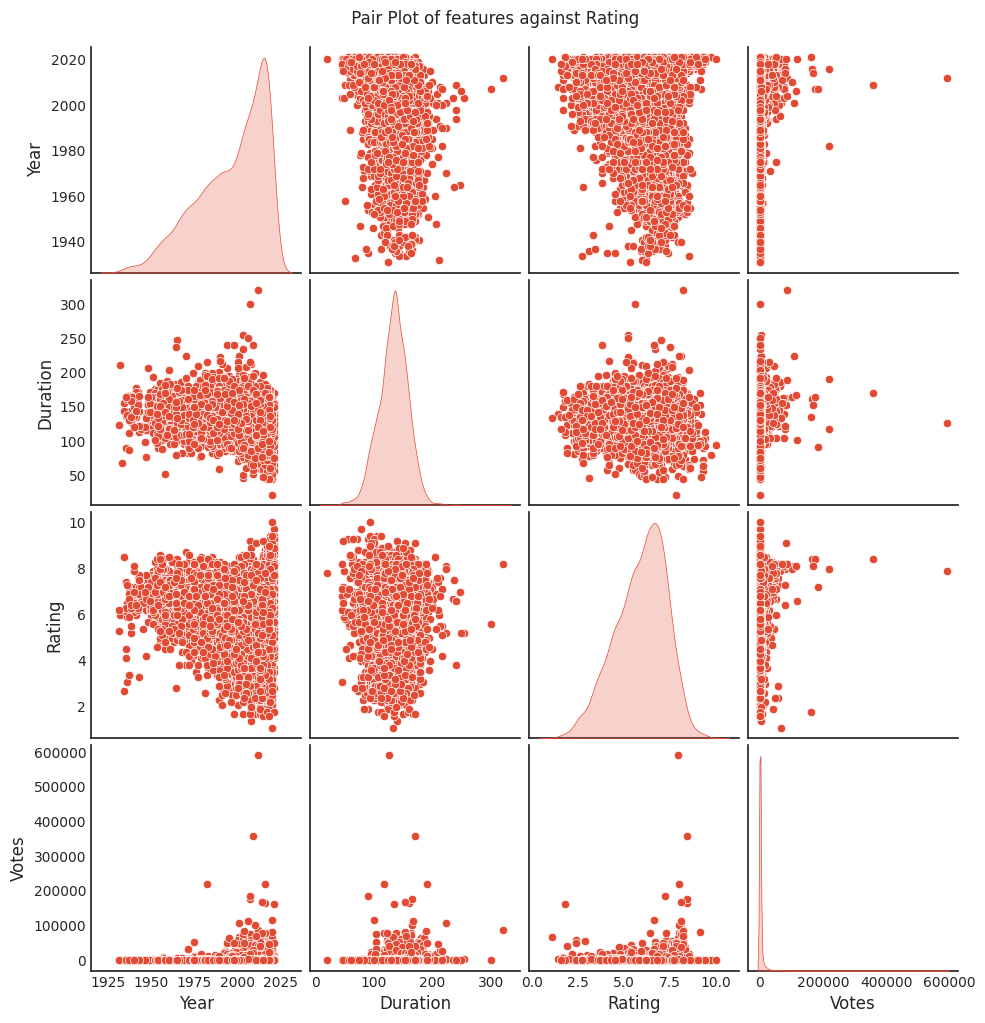

In [60]:
sns.pairplot(new_df,diag_kind='kde')
plt.suptitle(' Pair Plot of features against Rating', y=1.02)
plt.show()

Feature Engimeerimg

In [73]:
print(df.columns)


Index(['Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1',
       'Actor 2', 'Actor 3'],
      dtype='object')


In [74]:
if 'Name' in df.columns:
    df = df.drop('Name', axis=1)
else:
    print("Column 'Name' does not exist.")


Column 'Name' does not exist.


In [76]:
# Create new features 

Genre_Average_Rating = df.groupby('Genre')['Rating'].transform('mean')
df['Genre_Average_Rating'] =Genre_Average_Rating

Director_Average_Rating = df.groupby('Director')['Rating'].transform('mean')
df['Director_Average_Rating'] =Director_Average_Rating

Actor1_Average_Rating = df.groupby('Actor 1')['Rating'].transform('mean')
df['Actor1_Average_Rating'] =Actor1_Average_Rating

Actor2_Average_Rating = df.groupby('Actor 2')['Rating'].transform('mean')
df['Actor2_Average_Rating'] =Actor2_Average_Rating
Actor3_Average_Rating = df.groupby('Actor 3')['Rating'].transform('mean')
df['Actor3_Average_Rating'] =Actor3_Average_Rating

df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre_Average_Rating,Director_Average_Rating,Actor1_Average_Rating,Actor2_Average_Rating,Actor3_Average_Rating
1,2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,6.415521,7.000000,6.850000,7.000000,7.000000
3,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,5.716822,4.400000,5.420000,4.400000,4.450000
5,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,6.242222,5.313333,4.788889,5.786667,5.872727
6,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,6.820000,7.383333,5.435000,6.933333,6.500000
8,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.477778,5.600000,5.600000,5.883333,5.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15493,2015,115,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana,6.415521,6.100000,6.725000,6.100000,5.850000
15494,2001,153,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee,6.950000,7.250000,4.157143,5.823077,5.954545
15503,1989,125,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth,5.743465,6.270000,6.307692,5.800000,6.050000
15505,1999,129,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,5.516505,5.225000,5.481707,4.640000,5.737500


In [79]:
#Split dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Define feature and target variables
x= df[['Year','Votes','Duration','Genre_Average_Rating','Director_Average_Rating','Actor1_Average_Rating','Actor2_Average_Rating','Actor3_Average_Rating']]
y=df['Rating']

In [80]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2)
train_data= x_train.join(y_train)
train_data

,Year,Votes,Duration,Genre_Average_Rating,Director_Average_Rating,Actor1_Average_Rating,Actor2_Average_Rating,Actor3_Average_Rating,Rating
15388,1984,44,133,6.150000,5.540000,6.291358,6.035000,6.236842,5.5
3621,1982,536,165,5.477966,6.521053,6.183654,6.279167,5.350000,6.0
1747,2017,9,81,6.145455,3.250000,3.250000,3.250000,3.250000,2.3
11510,2016,137,120,6.334783,8.000000,8.000000,8.000000,8.000000,8.0
4020,1972,88,127,4.648649,6.100000,6.100000,6.100000,6.700000,6.1
...,...,...,...,...,...,...,...,...,...
12434,2016,247,112,5.726415,3.550000,5.050000,3.233333,4.511111,2.8
6551,1979,44,126,5.726415,6.083333,6.567568,6.452174,6.583333,6.5
4682,2016,27,97,6.100000,5.500000,6.362500,5.500000,6.480000,5.5
1017,1983,666,155,5.516505,5.360870,6.183654,5.563636,6.416667,6.1


Model Building

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

x_train, y_train = train_data[['Year','Votes','Duration','Genre_Average_Rating','Director_Average_Rating','Actor1_Average_Rating','Actor2_Average_Rating','Actor3_Average_Rating']], train_data['Rating']

#Build a Linear Regression model
fitted_model_lr = LinearRegression()
#Train the model
fitted_model_lr.fit(x_train,y_train)
#Make predictions
y_pred_lr = fitted_model_lr.predict(x_test)
#Build a Random Forest Model
fitted_model_rf = RandomForestRegressor()
#Train the model
fitted_model_rf.fit(x_train, y_train)
#Make predictions
y_pred_rf = fitted_model_rf.predict(x_test)

MOdel Evalution

In [82]:
# Evaluating the model's performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


MSE_lr =  mean_squared_error(y_test, y_pred_lr) 
MAE_lr = mean_absolute_error(y_test, y_pred_lr)
R2_Score_lr = r2_score(y_test, y_pred_lr)

print('   Performance Evaluation for Linear Regression Model: ')
print('Mean squared error value is: ', MSE_lr)
print('Mean absolute error value is: ', MAE_lr)
print('R2 score value is: ', R2_Score_lr)
MSE_rf =  mean_squared_error(y_test, y_pred_rf) 
MAE_rf = mean_absolute_error(y_test, y_pred_rf)
R2_Score_rf = r2_score(y_test, y_pred_rf)

print('\n   Performance Evaluation for Random Forest Model: ')
print('Mean squared error value is: ', MSE_rf)
print('Mean absolute error value is: ', MAE_rf)
print('R2 score value is: ', R2_Score_rf)

   Performance Evaluation for Linear Regression Model: 
Mean squared error value is:  0.42632658447378957
Mean absolute error value is:  0.4792263632997043
R2 score value is:  0.7776662164971028

   Performance Evaluation for Random Forest Model: 
Mean squared error value is:  0.3377169372791519
Mean absolute error value is:  0.3909973498233217
R2 score value is:  0.8238770765117494


Actual with predicted Analysis

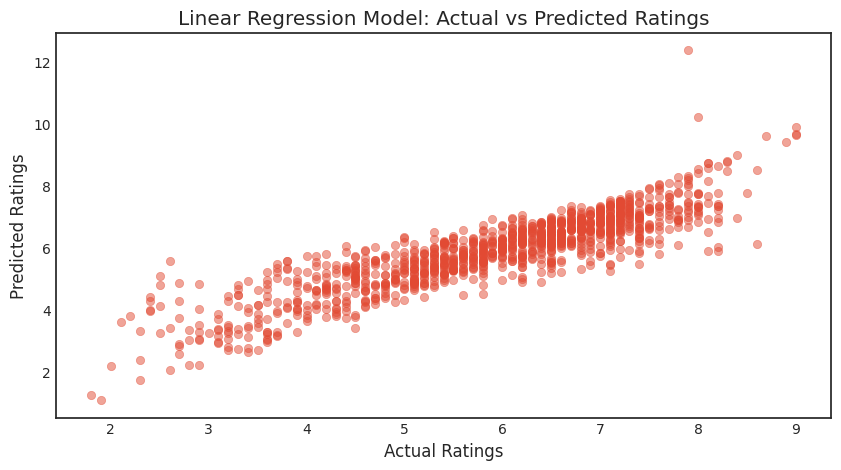

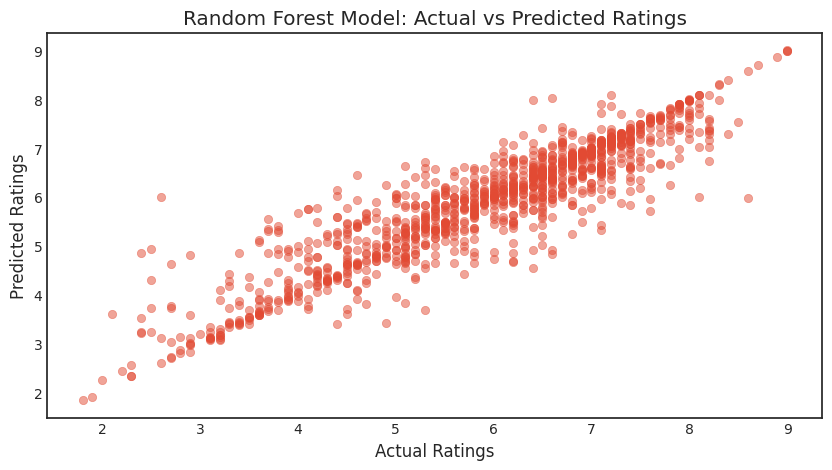

In [83]:
# Scatter plot for Linear Regression model predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.title('Linear Regression Model: Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

# Scatter plot for Random Forest model predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.title('Random Forest Model: Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

MOdel testimg 

In [84]:
x.head(10)

,Year,Votes,Duration,Genre_Average_Rating,Director_Average_Rating,Actor1_Average_Rating,Actor2_Average_Rating,Actor3_Average_Rating
1,2019,8,109,6.415521,7.000000,6.850000,7.000000,7.000000
3,2019,35,110,5.716822,4.400000,5.420000,4.400000,4.450000
5,1997,827,147,6.242222,5.313333,4.788889,5.786667,5.872727
6,2005,1086,142,6.820000,7.383333,5.435000,6.933333,6.500000
8,2012,326,82,5.477778,5.600000,5.600000,5.883333,5.600000
9,2014,11,116,5.337778,4.000000,4.000000,4.550000,4.000000
10,2004,17,96,6.415521,6.200000,5.480000,5.450000,5.233333
11,2016,59,120,4.648649,6.950000,6.066667,5.900000,5.900000
12,1991,983,161,5.400000,4.907143,5.187179,5.976190,5.041667
13,2012,512,166,5.765957,5.700000,6.300000,5.700000,5.700000


In [85]:
y.head(10)

1     7.0
3     4.4
5     4.7
6     7.4
8     5.6
9     4.0
10    6.2
11    5.9
12    6.5
13    5.7
Name: Rating, dtype: float64

In [86]:
# Create new trial dataframe to testing

data = {'Year': [2018], 'Votes': [100] ,'Duration': [130], 'Genre_Average_Rating':[6.0],'Director_Average_Rating':[6.5],'Actor1_Average_Rating':[5.5],'Actor2_Average_Rating':[5.8],'Actor3_Average_Rating':[5.3]}
trail_data = pd.DataFrame(data)

In [87]:
# Predict rating using trial data
predict_rating = fitted_model_rf.predict(trail_data)
print('Predicted Rating for trial data: ',predict_rating[0])

Predicted Rating for trial data:  5.861000000000001


**Conclusion :-**
A score of 5.86 indicates that the movie is perceived as average or slightly below average. In the context of IMDB ratings, which range from 1 to 10, this score may suggest that the movie lacks certain elements that resonate positively with audiences, such as strong storytelling, compelling performances, or high production values.
